In [ ]:
# Вывести все уникальные бренды, у которых есть хотя бы один продукт со стандартной стоимостью 
# выше 1500 долларов, и суммарными продажами не менее 1000 единиц.
SELECT DISTINCT brand 
FROM product_import
WHERE standard_cost > 1500 
AND brand IN (
    SELECT brand 
    FROM product_import as pi
    JOIN order_items as oi ON pi.product_id = oi.product_id
    GROUP BY brand 
    HAVING SUM(oi.quantity) >= 1000
);

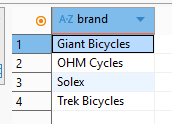

In [ ]:
# Для каждого дня в диапазоне с 2017-04-01 по 2017-04-09 включительно вывести количество 
# подтвержденных онлайн-заказов и количество уникальных клиентов, совершивших эти заказы.
SELECT 
    order_date,
    COUNT(*) as количество_заказов,
    COUNT(DISTINCT customer_id) as уникальные_клиенты
FROM orders 
WHERE order_date BETWEEN '2017-04-01' AND '2017-04-09'
    AND online_order = TRUE
    AND order_status = 'Approved'
GROUP BY order_date
ORDER BY order_date;

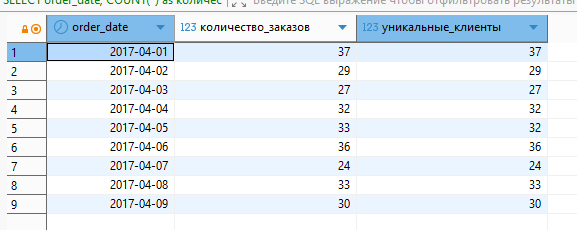


In [ ]:
# Вывести профессии клиентов:
# из сферы IT, чья профессия начинается с Senior;
# из сферы Financial Services, чья профессия начинается с Lead.
# Для обеих групп учитывать только клиентов старше 35 лет. Объединить выборки с помощью UNION ALL.

SELECT customer_id, first_name, last_name, job_title
FROM customer 
WHERE job_industry_category = 'IT' 
    AND job_title LIKE 'Senior%'
    AND age(current_date, DOB) > interval '35 years'

UNION ALL

SELECT customer_id, first_name, last_name, job_title
FROM customer 
WHERE job_industry_category = 'Financial Services' 
    AND job_title LIKE 'Lead%'
    AND age(current_date, DOB) > interval '35 years';

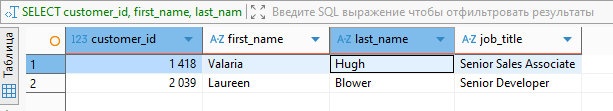

In [ ]:
# Вывести бренды, которые были куплены клиентами из сферы Financial Services, но не были куплены клиентами из сферы IT.
SELECT DISTINCT pi.brand
FROM orders as o
JOIN customer as c ON o.customer_id = c.customer_id
JOIN order_items as oi ON o.order_id = oi.order_id
JOIN product_import as pi ON oi.product_id = pi.product_id
WHERE c.job_industry_category = 'Financial Services'

EXCEPT

SELECT DISTINCT pi.brand
FROM orders as o
JOIN customer as c ON o.customer_id = c.customer_id
JOIN order_items as oi ON o.order_id = oi.order_id
JOIN product_import as pi ON oi.product_id = pi.product_id
WHERE c.job_industry_category = 'IT';

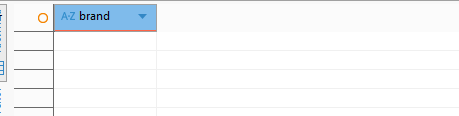

In [ ]:
# Вывести 10 клиентов (ID, имя, фамилия), которые совершили наибольшее количество онлайн-заказов (в штуках) 
# брендов Giant Bicycles, Norco Bicycles, Trek Bicycles, при условии, 
# что они активны и имеют оценку имущества (property_valuation) выше среднего среди клиентов из того же штата.
WITH state_averages AS (
    SELECT 
        state,
        AVG(property_valuation) as средняя_оценка
    FROM customer
    GROUP BY state
)

SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    COUNT(DISTINCT o.order_id) as количество_заказов

FROM customer as c
JOIN orders as o ON c.customer_id = o.customer_id
JOIN order_items as oi ON o.order_id = oi.order_id
JOIN product_import as pi ON oi.product_id = pi.product_id
JOIN state_averages as so ON c.state = so.state

WHERE 
    o.online_order = TRUE
    AND o.order_status = 'Approved'
    AND pi.brand IN ('Giant Bicycles', 'Norco Bicycles', 'Trek Bicycles')
    AND c.deceased_indicator = 'N'
    AND c.property_valuation > so.средняя_оценка

GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY количество_заказов DESC
LIMIT 10;

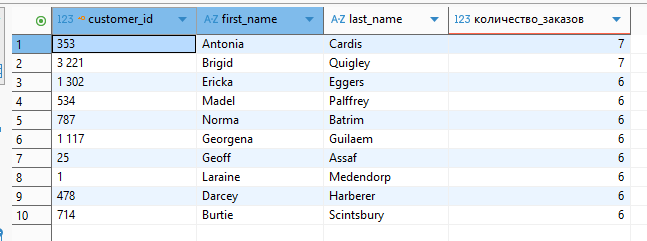

In [ ]:
# Вывести всех клиентов (ID, имя, фамилия), у которых нет подтвержденных онлайн-заказов за последний год, но при этом 
# они владеют автомобилем и их сегмент благосостояния не Mass Customer.
SELECT 
    customer_id,
    first_name,
    last_name
FROM customer
WHERE 
    owns_car = 'Yes'
    AND wealth_segment != 'Mass Customer'
    AND customer_id NOT IN (
        SELECT customer_id 
        FROM orders 
        WHERE 
            online_order = TRUE 
            AND order_status = 'Approved'
            AND order_date >= CURRENT_DATE - 365
    );

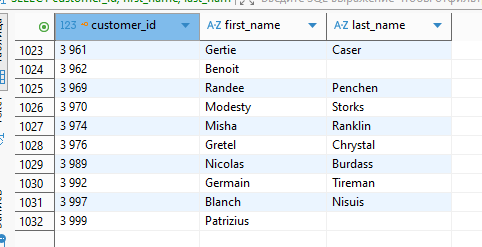

In [ ]:
# Вывести всех клиентов из сферы 'IT' (ID, имя, фамилия), которые купили 2 из 5 продуктов с 
# самой высокой list_price в продуктовой линейке Road.
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name
FROM customer as c
JOIN orders as o ON c.customer_id = o.customer_id
JOIN order_items as oi ON o.order_id = oi.order_id
JOIN product_import as pi ON oi.product_id = pi.product_id
WHERE c.job_industry_category = 'IT'
    AND pi.product_line = 'Road'
    AND o.order_status = 'Approved'
    AND pi.product_id IN (
        SELECT product_id 
        FROM product_import 
        WHERE product_line = 'Road'
        ORDER BY list_price DESC 
        LIMIT 5
    )
GROUP BY c.customer_id, c.first_name, c.last_name
HAVING COUNT(DISTINCT pi.product_id) >= 2;

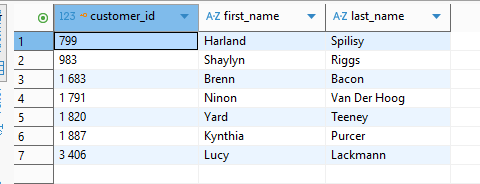

In [ ]:
# Вывести клиентов (ID, имя, фамилия, сфера деятельности) из сфер IT или Health, которые совершили не менее 3 
# подтвержденных заказов в период 2017-01-01 по 2017-03-01, и при этом их общий доход от этих заказов превышает 10 000 долларов.
# Разделить вывод на две группы (IT и Health) с помощью UNION.

SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    c.job_industry_category,
    SUM(oi.quantity * oi.item_list_price_at_sale) as общий_доход,
    COUNT(DISTINCT o.order_id) as количество_заказов
FROM customer as c
JOIN orders as o ON c.customer_id = o.customer_id
JOIN order_items as oi ON o.order_id = oi.order_id
WHERE c.job_industry_category = 'IT'
    AND o.order_date BETWEEN '2017-01-01' AND '2017-03-01'
    AND o.order_status = 'Approved'
GROUP BY c.customer_id, c.first_name, c.last_name, c.job_industry_category
HAVING COUNT(DISTINCT o.order_id) >= 3
    AND SUM(oi.quantity * oi.item_list_price_at_sale) > 10000

UNION

SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    c.job_industry_category,
    SUM(oi.quantity * oi.item_list_price_at_sale) as общий_доход,
    COUNT(DISTINCT o.order_id) as количество_заказов
FROM customer as c
JOIN orders as o ON c.customer_id = o.customer_id
JOIN order_items as oi ON o.order_id = oi.order_id
WHERE c.job_industry_category = 'Health'
    AND o.order_date BETWEEN '2017-01-01' AND '2017-03-01'
    AND o.order_status = 'Approved'
GROUP BY c.customer_id, c.first_name, c.last_name, c.job_industry_category
HAVING COUNT(DISTINCT o.order_id) >= 3
    AND SUM(oi.quantity * oi.item_list_price_at_sale) > 10000

ORDER BY job_industry_category, общий_доход DESC;

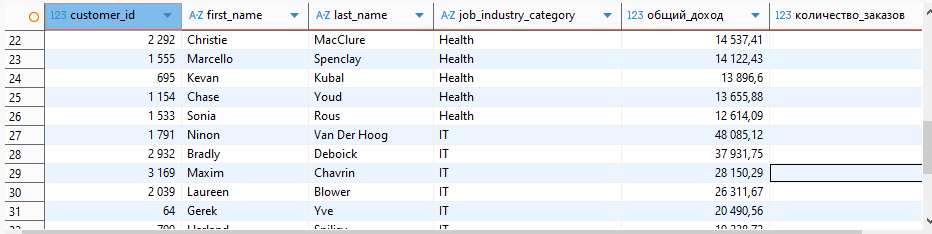